# UCI regression 

In [1]:
import jax
import optax
import pickle
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

import datagen
from functools import partial
from bayes_opt import BayesianOptimization
from jax.sharding import PositionalSharding
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gfilter
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
from time import time
from tqdm import tqdm

In [3]:
devices = jax.devices()
sharding = PositionalSharding(devices)

In [93]:
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 18

cmap = {
    "EKF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold", # TODO: make more o-paco
    "OGD": "blueviolet",
    "EKF-B": "darkorange",
}

%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    print(dataset_name, dataset.shape)

protein-tertiary-structure (45731, 10)
naval-propulsion-plant (11935, 18)
wine-quality-red (1600, 12)
bostonHousing (507, 14)
power-plant (9569, 5)
concrete (1031, 9)
energy (769, 9)
kin8nm (8193, 9)
yacht (309, 7)


In [6]:
dataset_name = "naval-propulsion-plant"
noise_type = "target" # or "covariate"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 100
v_error = 50
seed_init = 314
p_error = 0.30
for i in range(n_runs):
    if noise_type == "target":
        data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].astype(bool)
    elif noise_type == "covariate":
        data = uci.sample_noisy_covariates(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].any(axis=1).astype(bool)
    else:
        raise KeyError(f"Noise {noise_type} not available")
        
    X = data["X"]
    y = data["y"]
    
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [7]:
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T
X_collection.shape

(100, 10742, 17)

In [8]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Setup

In [9]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [10]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [11]:
Q = 0.0
observation_covariance = 1.0

In [12]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

In [13]:
X_collection.shape

(100, 10742, 17)

## EKF

In [14]:
def filter_ekf(log_lr):
    lr = np.exp(log_lr)
    agent = gfilter.ExtendedKalmanFilter(
        lambda x: x,
        model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance  * jnp.eye(1),
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(log_lr):
    res = -jnp.power(filter_ekf(log_lr)[0] - y, 2)
    res = np.median(res)
    
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [15]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 2         | -5.106    | -2.057    |
| 3         | -2.808    | -3.675    |
| 6         | -1.612    | -3.692    |
| 8         | -1.608    | -3.742    |
CPU times: user 22.6 s, sys: 23.9 s, total: 46.5 s
Wall time: 7.47 s


In [16]:
%%time

lr = np.exp(bo.max["params"]["log_lr"])
agent = gfilter.ExtendedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=Q,
    observation_covariance=1.0 * jnp.eye(1),
)

bel_init = agent.init_bel(params_init, cov=lr)

callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))
res = scanfn(bel_init, y_collection, X_collection, callback)

res = jax.block_until_ready(res)
state_final_collection, yhat_collection_ekf = res
yhat_collection_ekf = yhat_collection_ekf.squeeze()

CPU times: user 1.98 s, sys: 56.3 ms, total: 2.03 s
Wall time: 9.61 s


In [17]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]

CPU times: user 59.2 s, sys: 1.15 s, total: 1min
Wall time: 1min 5s


In [18]:
time_runs_ekf = pd.Series(time_runs, name="EKF")
err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)

/tmp/ipykernel_158655/1561462852.py:2: RuntimeWarning: overflow encountered in power
  err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)


## WLF-IMQ

### Hparam choice

In [19]:
def filter_imqf(soft_threshold, log_lr):
    lr = np.exp(log_lr)
    agent = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.link_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(soft_threshold, log_lr):
    # res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)
    res = jnp.median(res)
    
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [20]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "soft_threshold": (1e-6, 15),
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 4         | -0.09344  | -1.36     | 3.907     |
| 5         | -0.06084  | -0.4412   | 3.911     |
| 6         | -0.04573  | 0.0       | 2.787     |
CPU times: user 26.7 s, sys: 25.5 s, total: 52.2 s
Wall time: 10.3 s


### Eval

In [21]:
soft_threshold = bo.max["params"]["soft_threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = gbfilter.IMQFilter(
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0,
    soft_threshold=soft_threshold
)

In [22]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.link_fn)
_, yhat_collection_wlf = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_wlf = jax.block_until_ready(yhat_collection_wlf.squeeze())

CPU times: user 2.33 s, sys: 38.1 ms, total: 2.37 s
Wall time: 10 s


In [23]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]

CPU times: user 52.2 s, sys: 1.7 s, total: 53.9 s
Wall time: 1min 5s


In [24]:
time_runs_wlf = pd.Series(time_runs, name="WLF-IMQ")
err_collection_wlf = pd.DataFrame(np.power(y_collection - yhat_collection_wlf, 2).T)

## Inverse-Wishart-based EKF
(Agamenoni 2012)

### Hparam choice

In [94]:
def filter_rkf(noise_scaling, log_lr):
    lr = np.exp(log_lr)
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=2
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

In [95]:
def opt_step(noise_scaling, log_lr):
    # res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [96]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "noise_scaling": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | noise_... |
-------------------------------------------------
| 3         | -0.03151  | -0.41     | 12.41     |
| 5         | -0.0286   | -0.4412   | 3.911     |
CPU times: user 35.2 s, sys: 29.9 s, total: 1min 5s
Wall time: 13.8 s


### Eval

In [97]:
noise_scaling = bo.max["params"]["noise_scaling"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedRobustKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    prior_observation_covariance=1.0 * jnp.eye(1),
    n_inner=2,
    noise_scaling=noise_scaling,
)

In [98]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.vobs_fn)
_, yhat_collection_ann1 = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ann1 = jax.block_until_ready(yhat_collection_ann1.squeeze())

CPU times: user 3.73 s, sys: 33.4 ms, total: 3.76 s
Wall time: 27.5 s


In [99]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]

CPU times: user 1min 37s, sys: 1.47 s, total: 1min 39s
Wall time: 2min 1s


In [100]:
time_runs_ann1 = pd.Series(time_runs, name="EKF-IW")
err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)

/tmp/ipykernel_158655/2021172931.py:2: RuntimeWarning: overflow encountered in power
  err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)


## WLF-MD
Weighted likelihood filter with Mahalanobis distance thresholding weighting function

### Hparam section

In [32]:
def filter_mah_ekf(log_lr, threshold):
    lr = np.exp(log_lr)
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out

def opt_step(log_lr, threshold):
    res = -jnp.power(filter_mah_ekf(noise_scaling, log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [33]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "threshold": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
CPU times: user 28.3 s, sys: 27.6 s, total: 55.9 s
Wall time: 8.4 s


### Eval

In [34]:
threshold = bo.max["params"]["threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedThresholdedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
    threshold=threshold,
)

In [35]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
bel_init = jax.device_put(bel_init, sharding.replicate(0))
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))

_, yhat_collection_mekf = scanfn(bel_init, y_collection, X_collection, callback)
yhat_collection_mekf = jax.block_until_ready(yhat_collection_mekf)
yhat_collection_mekf = yhat_collection_mekf.squeeze()

CPU times: user 2.52 s, sys: 103 ms, total: 2.62 s
Wall time: 9.9 s


In [36]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]

CPU times: user 1min 5s, sys: 2.24 s, total: 1min 7s
Wall time: 1min 14s


In [37]:
time_runs_mekf = pd.Series(time_runs, name="WLF-MD")
err_collection_mekf = pd.DataFrame(np.power(y_collection - yhat_collection_mekf, 2).T)

## O-EKF
Outlier-based extended Kalman filter

In [101]:
def filter_oekf(log_lr, alpha, beta):
    """
    Outlier ekf
    """
    lr = np.exp(log_lr)
    agent_wang2018 = rfilter.OutlierDetectionExtendedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        # tol_inner=1e-3 # refactor
        n_inner=2
    )
    
    bel_init = agent_wang2018.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_wang2018.vobs_fn)
    
    bel_oekf, yhat_pp = agent_wang2018.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_wang2018, bel_oekf)
    return yhat_pp.squeeze(), out


def opt_step(log_lr, alpha, beta):
    res = -jnp.power(filter_oekf(log_lr, alpha, beta)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res):
        res = -1e+6
    
    return res

In [102]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |   alpha   |   beta    |  log_lr   |
-------------------------------------------------------------
| 2         | -0.09679  | 3.916     | 4.59      | -0.8632   |
| 3         | -0.0714   | 3.64      | 1.302     | -0.4412   |
| 7         | -0.04398  | 5.0       | 0.1547    | 0.0       |
| 10        | -0.04209  | 3.711     | 0.0       | 0.0       |
CPU times: user 35.3 s, sys: 29.8 s, total: 1min 5s
Wall time: 15.6 s


### Eval

In [103]:
log_lr = bo.max["params"]["log_lr"]
lr_oekf = np.exp(log_lr)
alpha = bo.max["params"]["alpha"]
beta = bo.max["params"]["beta"]

agent = rfilter.OutlierDetectionExtendedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        # tol_inner=1e-3 # refactor
        n_inner=2
    )


In [104]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
bel_init = jax.device_put(bel_init, sharding.replicate(0))
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.jit(jax.vmap(agent.scan, in_axes=(None, 0, 0, None)), static_argnames=("callback_fn",))

_, yhat_collection_oekf = scanfn(bel_init, y_collection, X_collection, callback)
yhat_collection_oekf = jax.block_until_ready(yhat_collection_oekf)
yhat_collection_oekf = yhat_collection_oekf.squeeze()

CPU times: user 2.78 s, sys: 67 ms, total: 2.84 s
Wall time: 17.8 s


In [105]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]

CPU times: user 1min 47s, sys: 2.96 s, total: 1min 50s
Wall time: 2min 29s


In [106]:
time_runs_oekf = pd.Series(time_runs, name="EKF-B")
err_collection_oekf = pd.DataFrame(np.power(y_collection - yhat_collection_oekf, 2).T)

## Online SGD

In [44]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

def filter_ogd(log_lr, n_inner):
    lr = np.exp(log_lr)
    n_inner = int(n_inner)
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=X.shape[-1],
        dim_output=1,
        n_inner=n_inner,
    )

    callback = partial(callback_fn, applyfn=model.apply)

    bel_init = agent.init_bel(params_init)
    bel_final, yhat_pp = agent.scan(bel_init, y, X, callback)
    out = (agent, bel_final)
    yhat_pp = yhat_pp.squeeze()

    return yhat_pp.squeeze(), out

def opt_step(log_lr, n_inner):
    res = -jnp.power(filter_ogd(log_lr, n_inner)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [45]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 2         | -3.48     | -3.675    | 8.049     |
| 6         | -0.9316   | -5.0      | 6.913     |
| 7         | -0.6327   | -4.635    | 3.028     |
| 10        | -0.4117   | -5.0      | 1.0       |
CPU times: user 29.9 s, sys: 30 s, total: 59.9 s
Wall time: 8.65 s


In [46]:
lr = jnp.exp(bo.max["params"]["log_lr"])
n_inner = int(bo.max["params"]["n_inner"])

agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    optax.adam(lr),
    buffer_size=1,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=n_inner
)

callback = partial(callback_fn, applyfn=model.apply)

bel_init = agent.init_bel(params_init)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)
jnp.sqrt(jnp.power(errs, 2).mean())

Array(27.506084, dtype=float32)

In [47]:
%%time
_, yhat_collection_ogd = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ogd = jax.block_until_ready(yhat_collection_ogd)
yhat_collection_ogd = yhat_collection_ogd.squeeze()

CPU times: user 869 ms, sys: 22 ms, total: 891 ms
Wall time: 730 ms


In [48]:
%%time

time_runs = []
for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs):
    time_init = time()
    _, y_est = agent.scan(bel_init, yc, Xc, callback)
    y_est = y_est.block_until_ready()
    time_end = time()
    time_runs.append(time_end - time_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]

CPU times: user 38.8 s, sys: 1.23 s, total: 40 s
Wall time: 38.8 s


In [49]:
time_runs_ogd = pd.Series(time_runs, name="OGD")
err_collection_ogd  = pd.DataFrame(np.power(y_collection - yhat_collection_ogd, 2).T)

# Results

In [107]:
import seaborn as sns

In [108]:
pd.set_option("display.float_format", lambda x: format(x, "0.4f"))

In [109]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "EKF": err_collection_ekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "OGD": err_collection_ogd.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "WLF-MD": err_collection_mekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "EKF-IW": err_collection_ann1.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "EKF-B": err_collection_oekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
})

df_results.describe()

/home/gerardoduran/mambaforge/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,WLF-IMQ,EKF,OGD,WLF-MD,EKF-IW,EKF-B
count,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
mean,0.0500,inf,0.4695,0.0410,inf,0.0538
std,0.0021,NaN,0.2530,0.0018,NaN,0.0505
min,0.0453,0.9778,0.1682,0.0366,0.0277,0.0391
25%,0.0488,2.0008,0.2917,0.0397,0.0302,0.0439
50%,0.0498,2.6115,0.4246,0.0407,0.0339,0.0452
75%,0.0510,3.9242,0.5773,0.0421,73658636126265450496.0000,0.0469
max,0.0564,inf,1.6184,0.0458,inf,0.5379


In [110]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.median(axis=0),
    "EKF": err_collection_ekf.median(axis=0),
    "OGD": err_collection_ogd.median(axis=0),
    "WLF-MD": err_collection_mekf.median(axis=0),
    "EKF-IW": err_collection_ann1.median(axis=0),
    "EKF-B": err_collection_oekf.median(axis=0),
})
df_results = np.sqrt(df_results)
df_results.describe()

,WLF-IMQ,EKF,OGD,WLF-MD,EKF-IW,EKF-B
count,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
mean,0.2511,1.3769,0.6229,0.2150,6052788.0000,0.2337
std,0.0073,0.3240,0.1344,0.0078,60488996.0000,0.0185
min,0.2327,0.8275,0.4011,0.1990,0.1589,0.1889
25%,0.2477,1.1570,0.5110,0.2089,0.1712,0.2276
50%,0.2508,1.3177,0.6031,0.2142,0.1833,0.2304
75%,0.2556,1.5279,0.7207,0.2205,0.2915,0.2377
max,0.2754,2.6642,0.9974,0.2379,604893760.0000,0.3768


In [111]:
df_time = pd.concat([
    time_runs_ekf,
    time_runs_wlf,
    time_runs_ann1,
    time_runs_oekf,
    time_runs_ogd,
    time_runs_mekf
], axis=1)

In [112]:
df_all = pd.merge(
    df_results.reset_index().melt("index", value_name="err"),
    df_time.reset_index().melt("index", value_name="time"),
    on=["index", "variable"],
)

df_all

,index,variable,err,time
0,0,WLF-IMQ,0.2548,0.6624
1,1,WLF-IMQ,0.2556,0.6495
2,2,WLF-IMQ,0.2587,0.6495
3,3,WLF-IMQ,0.2542,0.6508
4,4,WLF-IMQ,0.2667,0.6503
...,...,...,...,...
595,95,EKF-B,0.2311,1.4741
596,96,EKF-B,0.2275,1.4828
597,97,EKF-B,0.2339,1.5045
598,98,EKF-B,0.2380,1.4809


In [113]:
summary = df_all.pivot_table(index="variable", values=["err", "time"], aggfunc="median")
summary

,err,time
variable,,
EKF,1.3177,0.6328
EKF-B,0.2304,1.4812
EKF-IW,0.1833,1.2062
OGD,0.6031,0.3823
WLF-IMQ,0.2508,0.6461
WLF-MD,0.2142,0.7364


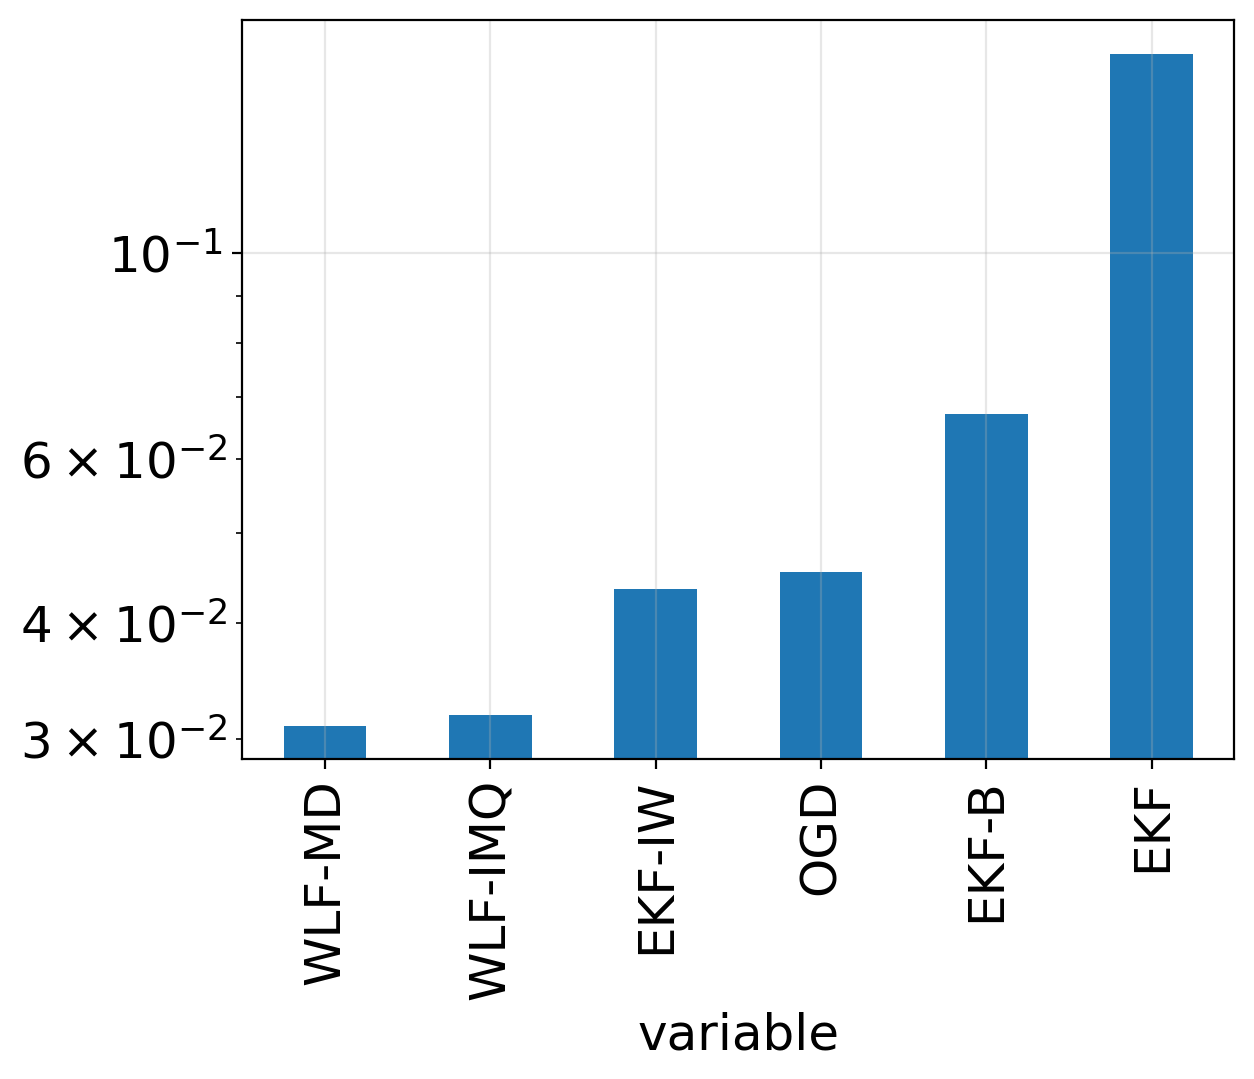

In [114]:
((summary["err"] * summary["time"]) / summary["time"].sum()).sort_values().plot(kind="bar")
plt.grid(alpha=0.3)
plt.yscale("log")

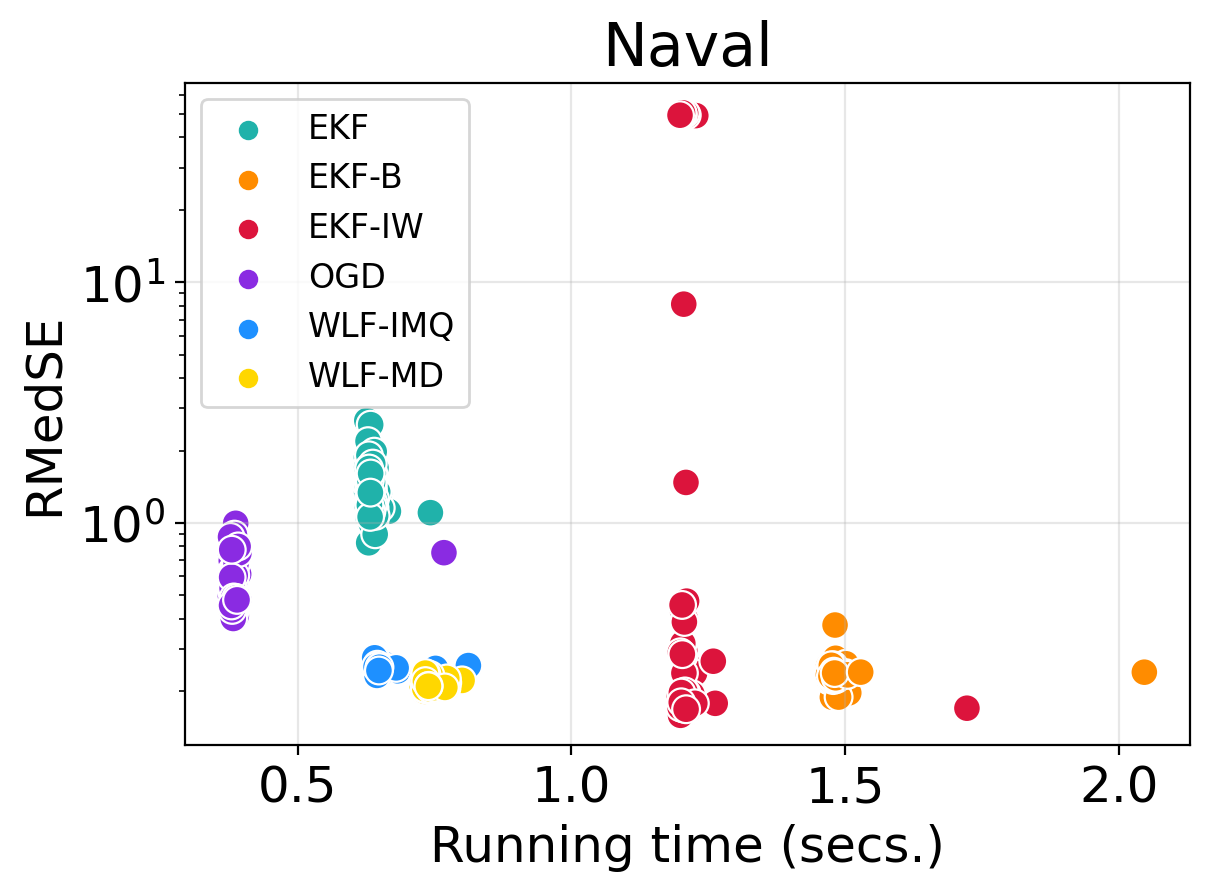

In [115]:
algorithms = sorted(cmap.keys())

title = dataset_name.split("-")[0]
sns.scatterplot(
    y="err", x="time", hue="variable", data=df_all.query("err < 10 ** 2"), palette=cmap, s=100,
    hue_order=algorithms,
)
plt.yscale("log")
plt.legend(ncol=1, loc="upper left", fontsize=12)
plt.title(title.capitalize())
plt.xlabel("Running time (secs.)")
plt.ylabel("RMedSE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"./figures/{title}-time-v-err.png", dpi=300)